In [1]:
#pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#conda install librosa soundfile numpy sklearn pyaudio #python package for music and audio analysis


Note: you may need to restart the kernel to use updated packages.



CondaValueError: invalid package specification: #python



In [35]:
# pip install pydub
# from pydub import AudioSegment

SyntaxError: invalid syntax (<ipython-input-35-554805d18422>, line 1)

In [75]:
# pip install hmmlearn

In [42]:
#conda install -c anaconda pyaudio

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\R.N.Mandal\anaconda3

  added / updated specs:
    - pyaudio


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> anaconda::ca-certificates-2020.10.14-0
  certifi            conda-forge::certifi-2020.12.5-py38ha~ --> anaconda::certifi-2020.6.20-py38_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [8]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [3]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [4]:
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles
dirName = './Ravdess'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1440

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
# import speech_recognition as sr
# r=sr.Recognizer()
# for file in range(0 , len(listOfFiles) , 1):
#     with sr.AudioFile(listOfFiles[file]) as source:
#         audio = r.listen(source)
#         try:
#             text = r.recognize_google(audio)
#             print(text)
#         except:
#             print('error')

talking by the door
is it talking by the door
dog sitting by the door
talk to Siri why the door
error
error
error
dog sitting by the door
change your talking by the door
kids talking by the door
dogs sitting by the door
sitting by the
kids talking by the door
talking by the door
dog sitting by the door
error
talking by the door
error
sitting by the door
error
kids talking by the door
khesa talking by the door
error
error
kids talking by the door
talking by the door
dogs sitting by the door
sitting by the door
talking by the door
is a talking by the door
the door
error
the door
Earth talking by the door
frogs are sitting by the door
dogs are sitting at the door
talking by the door
kids talking by the door
dogs sitting by the door
dogs sitting by the door
f****** by the door
is the talking to the door
Rockstar ceiling by the door
error
error
khinch
sitting by the door
coronavirus
kids talking by the door
talking by the door
tour tour
exit the door
kids talking
kids talking by the door
do

kids talking brother
talking brother
toxicity
error
kids talking body
kids talk about
error
error
kg chocolate
error
dogs 7
dogs
talking by the door
kids talking by the door
transistor inverter
dogs sitting by the door
parking
trujet
error
error
kg theatre Coimbatore
khesari.in
error
Raja Singh
error
Satta King
Tods shoes
Bobby Deol
kids talking point
kids talking brother
dogs sitting
error
photo photo
error
error
error
pk Satta King
Kidhar bhag 2
talk to Siri
accessories
error
error
error
Cricbuzz
talking to work
error
largest river in the world
Tarzan cinema network
kids talking brother
keep talking
error
error
talk about the world
kids talking about the door
Syrian border door
error
talking
talking by the door
setting border to word
Siri
kids talking by the river
kids are talking by the door
setting
dogs of sitting by the door
error
talking by the door
restaurant By The River
dog resting by the door
the talking by the door
kids talking by the door
error
Agra sitting by the door
talk

In [5]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    a=0
    for file in glob.glob("C:\\Users\\R.N.Mandal\\Desktop\\AVER\\Ravdess\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            a+=1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9) # split the data to training and testing and return it

In [4]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [7]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [11]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))
#print(np.shape(x_train),np.shape(x_test), np.shape(y_train),np.shape(y_test))

(576, 192)


In [12]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [13]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [14]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [15]:
#Predict for the test set
y_pred=model.predict(x_test)

In [16]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 70.83%


In [22]:
import glob,pickle
from tqdm import tqdm
from scipy.io import wavfile
for file in tqdm(glob.glob(r'C:\Users\R.N.Mandal\Desktop\AVER\Ravdess\\**\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'C:\Users\R.N.Mandal\Desktop\AVER\clean_ravdess\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1440/1440 [00:30<00:00, 47.37it/s]


In [24]:
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'C:\Users\R.N.Mandal\Desktop\AVER\clean_ravdess\\*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [25]:
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-06-01-02-02-01.wav
03-01-03-01-02-01-21.wav
03-01-07-01-02-02-04.wav
03-01-02-02-01-02-24.wav
03-01-07-01-02-02-19.wav
03-01-06-01-01-01-07.wav
03-01-07-01-01-01-16.wav
03-01-02-01-02-02-06.wav
03-01-06-01-01-02-07.wav
03-01-06-02-01-01-15.wav
03-01-02-02-02-02-07.wav
03-01-06-01-02-02-19.wav
03-01-06-02-02-02-05.wav
03-01-06-01-01-01-14.wav
03-01-06-01-02-01-15.wav
03-01-03-02-02-01-06.wav
03-01-02-01-01-02-16.wav
03-01-07-01-01-01-13.wav
03-01-03-02-02-02-24.wav
03-01-02-01-02-02-19.wav
03-01-02-02-01-02-09.wav
03-01-02-01-01-02-07.wav
03-01-03-01-02-01-13.wav
03-01-02-01-02-01-18.wav
03-01-02-02-02-02-03.wav
03-01-02-02-01-01-11.wav
03-01-03-01-02-02-20.wav
03-01-03-02-01-02-06.wav
03-01-06-01-01-02-11.wav
03-01-03-01-02-01-18.wav
03-01-06-01-01-01-15.wav
03-01-07-02-01-02-08.wav
03-01-07-02-01-02-23.wav
03-01-03-01-02-02-10.wav
03-01-06-01-01-01-23.wav
03-01-07-02-02-01-18.wav
03-01-06-02-02-01-22.wav
03-01-07-02-01-01-21.

In [27]:

print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [28]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [29]:
y_pred=model.predict(x_test)

In [30]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 78.12%


In [14]:
# if not os.path.isdir("result"):
#     os.mkdir("result")

# pickle.dump(model, open("result/speechmlp_classifier.model", "wb"))

In [31]:
Pkl_Filename = "CleanEmotionModel.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [6]:
# Load the Model back from file
with open("CleanEmotionModel.pkl", 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [33]:
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['disgust', 'happy', 'happy', 'calm', 'disgust', 'calm', 'disgust',
       'calm', 'fearful', 'disgust', 'calm', 'fearful', 'happy',
       'fearful', 'fearful', 'happy', 'calm', 'disgust', 'fearful',
       'calm', 'calm', 'calm', 'happy', 'calm', 'calm', 'calm', 'fearful',
       'happy', 'disgust', 'calm', 'disgust', 'disgust', 'disgust',
       'happy', 'fearful', 'disgust', 'fearful', 'disgust', 'disgust',
       'disgust', 'disgust', 'calm', 'happy', 'fearful', 'fearful',
       'calm', 'fearful', 'disgust', 'calm', 'calm', 'happy', 'happy',
       'happy', 'disgust', 'disgust', 'disgust', 'happy', 'disgust',
       'happy', 'calm', 'calm', 'happy', 'disgust', 'fearful', 'disgust',
       'fearful', 'calm', 'happy', 'fearful', 'disgust', 'happy', 'calm',
       'calm', 'calm', 'happy', 'calm', 'disgust', 'disgust', 'disgust',
       'disgust', 'happy', 'happy', 'fearful', 'fearful', 'disgust',
       'fearful', 'happy', 'fearful', 'disgust', 'fearful', 'calm',
       'happy

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        calm       0.91      0.53      0.67        57
     disgust       0.49      0.75      0.60        48
     fearful       0.40      0.84      0.54        37
       happy       0.75      0.12      0.21        50

    accuracy                           0.54       192
   macro avg       0.64      0.56      0.50       192
weighted avg       0.67      0.54      0.50       192



from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm)
sns.heatmap(df_cm,cm,annot=True,fmt='')
plt.title('Confusion Matrix',size=20)
plt.xlabel('predicted Labels',size=14)
plt.ylabel('Actual Labels',size=14)
#plt.savefig('Init.png')
plt.show()

In [34]:
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionRavdess.csv')

    predictions                file_names
0       disgust  03-01-06-01-02-02-01.wav
1         happy  03-01-03-01-02-01-21.wav
2         happy  03-01-07-01-02-02-04.wav
3          calm  03-01-02-02-01-02-24.wav
4       disgust  03-01-07-01-02-02-19.wav
..          ...                       ...
187     disgust  03-01-07-01-02-02-14.wav
188       happy  03-01-03-02-02-02-02.wav
189     fearful  03-01-06-02-01-01-14.wav
190     disgust  03-01-07-01-01-02-02.wav
191        calm  03-01-02-02-02-01-22.wav

[192 rows x 2 columns]


In [2]:
with open("result/speechmlp_classifier.model", 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

C:\Users\R.N.Mandal\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\R.N.Mandal\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

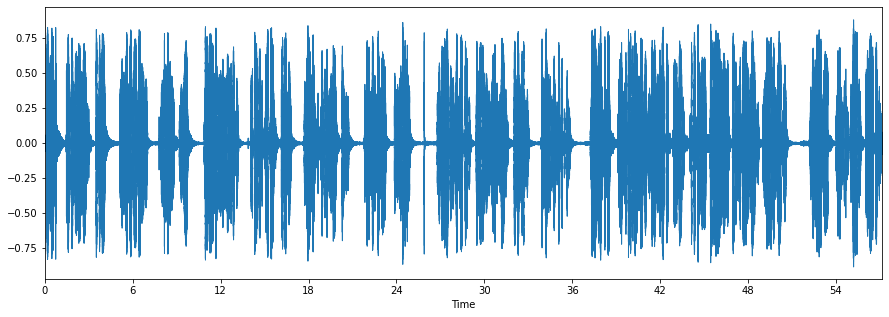

In [75]:
import matplotlib.pyplot as plt
data, sampling_rate = librosa.load('chunk4.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [20]:
#conda config --add channels conda-forge 



Note: you may need to restart the kernel to use updated packages.


In [22]:
#conda update --all

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\R.N.Mandal\anaconda3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2020.07  |           py38_0           6 KB
    alabaster-0.7.12           |             py_0          15 KB  conda-forge
    anaconda-custom            |           py38_1          36 KB
    anaconda-client-1.7.2      |             py_0          69 KB  conda-forge
    anaconda-project-0.9.1     |     pyhd8ed1ab_0         218 KB  conda-forge
    anyio-2.2.0                |   py38haa244fe_0         116 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    argh-0.26.2                |  pyh9f0ad1d_1002          26 KB  conda-forge
    argon2-cffi-20.1.0         |   py38h294d835_2          51 KB  conda-forge
    asn1crypto-1.4.0           |     pyh9f0ad1d_0          78 K

DEBUG menuinst_win32:__init__(198): Menu: name: 'Anaconda${PY_VER} ${PLATFORM}', prefix: 'C:\Users\R.N.Mandal\anaconda3', env_name: 'None', mode: 'user', used_mode: 'user'
DEBUG menuinst_win32:create(323): Shortcut cmd is C:\Users\R.N.Mandal\anaconda3\pythonw.exe, args are ['C:\\Users\\R.N.Mandal\\anaconda3\\cwp.py', 'C:\\Users\\R.N.Mandal\\anaconda3', 'C:\\Users\\R.N.Mandal\\anaconda3\\pythonw.exe', 'C:\\Users\\R.N.Mandal\\anaconda3\\Scripts\\spyder-script.py']
DEBUG menuinst_win32:create(323): Shortcut cmd is C:\Users\R.N.Mandal\anaconda3\python.exe, args are ['C:\\Users\\R.N.Mandal\\anaconda3\\cwp.py', 'C:\\Users\\R.N.Mandal\\anaconda3', 'C:\\Users\\R.N.Mandal\\anaconda3\\python.exe', 'C:\\Users\\R.N.Mandal\\anaconda3\\Scripts\\spyder-script.py', '--reset']
DEBUG menuinst_win32:__init__(198): Menu: name: 'Anaconda${PY_VER} ${PLATFORM}', prefix: 'C:\Users\R.N.Mandal\anaconda3', env_name: 'None', mode: 'user', used_mode: 'user'
DEBUG menuinst_win32:create(323): Shortcut cmd is C:\User


    bitarray-1.7.1             |   py38h294d835_0          96 KB  conda-forge
    black-20.8b1               |             py_1         103 KB  conda-forge
    bleach-3.3.0               |     pyh44b312d_0         111 KB  conda-forge
    blosc-1.21.0               |       h0e60522_0         688 KB  conda-forge
    bokeh-2.3.0                |   py38haa244fe_0         8.3 MB  conda-forge
    boto-2.49.0                |             py_0         838 KB  conda-forge
    bottleneck-1.3.2           |   py38h347fdf6_3         114 KB  conda-forge
    brotli-1.0.9               |       h0e60522_4         882 KB  conda-forge
    brotlipy-0.7.0             |py38h294d835_1001         368 KB  conda-forge
    bzip2-1.0.8                |       h8ffe710_4         149 KB  conda-forge
    ca-certificates-2020.12.5  |       h5b45459_0         173 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 K

In [64]:
import wave
obj = wave.open('chunk4.wav','r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()

Number of channels 2
Sample width 2
Frame rate. 44100
Number of frames 2520138
parameters: _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=2520138, comptype='NONE', compname='not compressed')


In [8]:
import wave
obj = wave.open('03-01-02-01-01-02-06.wav','r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()

Number of channels 1
Sample width 2
Frame rate. 16000
Number of frames 65666
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=65666, comptype='NONE', compname='not compressed')


In [73]:
import wave
obj = wave.open('chunkchannel_1.wav','r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
obj.close()

Number of channels 1
Sample width 2
Frame rate. 44100
Number of frames 2520138
parameters: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=2520138, comptype='NONE', compname='not compressed')


In [65]:
from scipy.io import wavfile

fs, data = wavfile.read('chunk4.wav')            # reading the file

wavfile.write('chunkchannel_1.wav', fs, data[:, 0])   # saving first column which corresponds to channel 1
wavfile.write('chunkchannel_2.wav', fs, data[:, 1])

In [5]:
file = 'chunkchannel_1.wav' #channel set to 1
ans =[]
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
print (new_feature)
print(np.shape(new_feature))
ans.append(new_feature)

ans = np.array(ans)
print(np.shape(ans))
try:
  print(Emotion_Voice_Detection_Model.predict([ans]))
except:
  print("An exception occurred")
#Emotion_Voice_Detection_Model.predict([ans])

[-2.63951111e+02  1.09196487e+02 -2.35478687e+01  1.53101168e+01
 -1.56890392e+01 -3.79026628e+00 -2.22364407e+01 -8.35200214e+00
 -2.25083160e+01 -2.18681183e+01 -1.61357307e+01 -1.97900791e+01
 -9.17027760e+00 -1.14603491e+01 -8.87360191e+00  1.06001461e+00
 -1.38177061e+00 -8.73414898e+00 -1.24653852e+00 -6.16787815e+00
 -4.20024014e+00 -7.21634007e+00 -5.15412951e+00 -5.07060528e+00
 -5.98534203e+00 -2.96882010e+00 -4.33370209e+00 -2.41858289e-01
 -1.64866611e-01  1.48652041e+00  6.32396698e-01  4.22976112e+00
  8.50229681e-01  2.04047418e+00  1.69705141e+00  4.24935758e-01
  1.78301191e+00  1.63527334e+00  3.66667223e+00  4.63462532e-01
  6.04041874e-01  6.12379193e-01  5.74256361e-01  5.11513352e-01
  5.01899481e-01  4.90761399e-01  4.83331531e-01  5.03887892e-01
  5.31942785e-01  5.63771427e-01  5.65476298e-01  5.77016950e-01
  3.34906834e-03  1.21145304e-02  3.79848890e-02  1.24816351e-01
  5.26822627e-01  2.34029484e+00  8.51986027e+00  1.67659035e+01
  2.46528625e+01  1.84085

In [9]:
file = 'chunkchannel_1.wav' #channel set to 1
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
try:
  print(Emotion_Voice_Detection_Model.predict([new_feature]))
except:
  print("An exception occurred")

['fearful']


In [41]:
from scipy.io import wavfile

fs, data = wavfile.read('C:/Users/R.N.Mandal/Desktop/AVER/audio_chunks/audio_NICKVUJICIC/chunk2.wav')            # reading the file

wavfile.write('chunk2_1.wav', fs, data[:, 0])   # saving first column which corresponds to channel 1
wavfile.write('chunk2_2.wav', fs, data[:, 1])

In [42]:
file = 'chunk2_1.wav' #channel set to 1
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
try:
  print(Emotion_Voice_Detection_Model.predict([new_feature]))
except:
  print("An exception occurred")

['happy']


In [31]:
from scipy.io import wavfile

fs, data = wavfile.read('C:/Users/R.N.Mandal/Desktop/AVER/audio_chunks/audio_rock_oprah/chunk16.wav')# reading the file

wavfile.write('chunk16_1.wav', fs, data[:, 0])   # saving first column which corresponds to channel 1
wavfile.write('chunk16_2.wav', fs, data[:, 1])

In [33]:
file = 'chunk16_2.wav' #channel set to 1
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
try:
  print(Emotion_Voice_Detection_Model.predict([new_feature]))
except:
  print("An exception occurred")

An exception occurred


In [5]:
import glob,pickle
from tqdm import tqdm
from scipy.io import wavfile
for file in tqdm(glob.glob(r'C:\Users\R.N.Mandal\Desktop\AVER\audio_chunks\\audio_*\\*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=44100)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'C:\Users\R.N.Mandal\Desktop\AVER\clean_audiochunks\\'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


In [9]:
import glob,pickle
from tqdm import tqdm
from scipy.io import wavfile
a=[]
for file in glob.glob("C:\\Users\\R.N.Mandal\\Desktop\\AVER\\clean_*\\*.wav"):
    file_name = os.path.basename(file)
    print(file_name)
    new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
    print(Emotion_Voice_Detection_Model.predict([new_feature]))

chunk0.wav
['fearful']
chunk1.wav
['fearful']
chunk10.wav
['fearful']
chunk100.wav
['fearful']
chunk101.wav
['happy']
chunk102.wav
['fearful']
chunk103.wav
['fearful']
chunk104.wav
['fearful']
chunk105.wav
['fearful']
chunk106.wav
['fearful']
chunk107.wav
['fearful']
chunk108.wav
['fearful']
chunk109.wav
['fearful']
chunk11.wav
['fearful']
chunk110.wav
['fearful']
chunk111.wav
['fearful']
chunk112.wav
['fearful']
chunk113.wav
['happy']
chunk114.wav
['fearful']
chunk115.wav
['fearful']
chunk116.wav
['fearful']
chunk117.wav
['fearful']
chunk118.wav
['fearful']
chunk119.wav
['fearful']
chunk12.wav
['fearful']
chunk120.wav
['fearful']
chunk121.wav
['fearful']
chunk122.wav
['fearful']
chunk123.wav
['fearful']
chunk124.wav
['fearful']
chunk125.wav
['happy']
chunk126.wav
['fearful']
chunk127.wav
['fearful']
chunk128.wav
['fearful']
chunk129.wav
['fearful']
chunk13.wav
['fearful']
chunk130.wav
['fearful']
chunk131.wav
['fearful']
chunk132.wav
['fearful']
chunk133.wav
['fearful']
chunk134.wav
[

['calm']
03-01-02-01-02-01-02.wav
['calm']
03-01-02-01-02-01-03.wav
['calm']
03-01-02-01-02-01-04.wav
['calm']
03-01-02-01-02-01-05.wav
['calm']
03-01-02-01-02-01-06.wav
['calm']
03-01-02-01-02-01-07.wav
['calm']
03-01-02-01-02-01-08.wav
['calm']
03-01-02-01-02-01-09.wav
['calm']
03-01-02-01-02-01-10.wav
['calm']
03-01-02-01-02-01-11.wav
['calm']
03-01-02-01-02-01-12.wav
['calm']
03-01-02-01-02-01-13.wav
['calm']
03-01-02-01-02-01-14.wav
['calm']
03-01-02-01-02-01-15.wav
['calm']
03-01-02-01-02-01-16.wav
['calm']
03-01-02-01-02-01-17.wav
['calm']
03-01-02-01-02-01-18.wav
['calm']
03-01-02-01-02-01-19.wav
['calm']
03-01-02-01-02-01-20.wav
['calm']
03-01-02-01-02-01-21.wav
['calm']
03-01-02-01-02-01-22.wav
['calm']
03-01-02-01-02-01-23.wav
['disgust']
03-01-02-01-02-01-24.wav
['calm']
03-01-02-01-02-02-01.wav
['calm']
03-01-02-01-02-02-02.wav
['calm']
03-01-02-01-02-02-03.wav
['calm']
03-01-02-01-02-02-04.wav
['calm']
03-01-02-01-02-02-05.wav
['calm']
03-01-02-01-02-02-06.wav
['calm']
03

['happy']
03-01-03-02-01-01-01.wav
['happy']
03-01-03-02-01-01-02.wav
['happy']
03-01-03-02-01-01-03.wav
['happy']
03-01-03-02-01-01-04.wav
['happy']
03-01-03-02-01-01-05.wav
['happy']
03-01-03-02-01-01-06.wav
['happy']
03-01-03-02-01-01-07.wav
['happy']
03-01-03-02-01-01-08.wav
['happy']
03-01-03-02-01-01-09.wav
['happy']
03-01-03-02-01-01-10.wav
['happy']
03-01-03-02-01-01-11.wav
['happy']
03-01-03-02-01-01-12.wav
['happy']
03-01-03-02-01-01-13.wav
['happy']
03-01-03-02-01-01-14.wav
['happy']
03-01-03-02-01-01-15.wav
['happy']
03-01-03-02-01-01-16.wav
['happy']
03-01-03-02-01-01-17.wav
['happy']
03-01-03-02-01-01-18.wav
['happy']
03-01-03-02-01-01-19.wav
['happy']
03-01-03-02-01-01-20.wav
['happy']
03-01-03-02-01-01-21.wav
['happy']
03-01-03-02-01-01-22.wav
['happy']
03-01-03-02-01-01-23.wav
['happy']
03-01-03-02-01-01-24.wav
['happy']
03-01-03-02-01-02-01.wav
['happy']
03-01-03-02-01-02-02.wav
['happy']
03-01-03-02-01-02-03.wav
['happy']
03-01-03-02-01-02-04.wav
['happy']
03-01-03-0

['happy']
03-01-04-02-01-02-22.wav
['fearful']
03-01-04-02-01-02-23.wav
['calm']
03-01-04-02-01-02-24.wav
['disgust']
03-01-04-02-02-01-01.wav
['happy']
03-01-04-02-02-01-02.wav
['disgust']
03-01-04-02-02-01-03.wav
['fearful']
03-01-04-02-02-01-04.wav
['fearful']
03-01-04-02-02-01-05.wav
['fearful']
03-01-04-02-02-01-06.wav
['disgust']
03-01-04-02-02-01-07.wav
['fearful']
03-01-04-02-02-01-08.wav
['fearful']
03-01-04-02-02-01-09.wav
['fearful']
03-01-04-02-02-01-10.wav
['disgust']
03-01-04-02-02-01-11.wav
['happy']
03-01-04-02-02-01-12.wav
['fearful']
03-01-04-02-02-01-13.wav
['disgust']
03-01-04-02-02-01-14.wav
['fearful']
03-01-04-02-02-01-15.wav
['happy']
03-01-04-02-02-01-16.wav
['happy']
03-01-04-02-02-01-17.wav
['disgust']
03-01-04-02-02-01-18.wav
['fearful']
03-01-04-02-02-01-19.wav
['fearful']
03-01-04-02-02-01-20.wav
['disgust']
03-01-04-02-02-01-21.wav
['happy']
03-01-04-02-02-01-22.wav
['disgust']
03-01-04-02-02-01-23.wav
['calm']
03-01-04-02-02-01-24.wav
['disgust']
03-01-0

['fearful']
03-01-05-02-02-02-10.wav
['happy']
03-01-05-02-02-02-11.wav
['fearful']
03-01-05-02-02-02-12.wav
['fearful']
03-01-05-02-02-02-13.wav
['fearful']
03-01-05-02-02-02-14.wav
['fearful']
03-01-05-02-02-02-15.wav
['fearful']
03-01-05-02-02-02-16.wav
['disgust']
03-01-05-02-02-02-17.wav
['happy']
03-01-05-02-02-02-18.wav
['happy']
03-01-05-02-02-02-19.wav
['fearful']
03-01-05-02-02-02-20.wav
['disgust']
03-01-05-02-02-02-21.wav
['fearful']
03-01-05-02-02-02-22.wav
['happy']
03-01-05-02-02-02-23.wav
['fearful']
03-01-05-02-02-02-24.wav
['happy']
03-01-06-01-01-01-01.wav
['fearful']
03-01-06-01-01-01-02.wav
['fearful']
03-01-06-01-01-01-03.wav
['fearful']
03-01-06-01-01-01-04.wav
['fearful']
03-01-06-01-01-01-05.wav
['fearful']
03-01-06-01-01-01-06.wav
['fearful']
03-01-06-01-01-01-07.wav
['calm']
03-01-06-01-01-01-08.wav
['fearful']
03-01-06-01-01-01-09.wav
['fearful']
03-01-06-01-01-01-10.wav
['fearful']
03-01-06-01-01-01-11.wav
['disgust']
03-01-06-01-01-01-12.wav
['fearful']
03

['disgust']
03-01-07-01-01-01-23.wav
['disgust']
03-01-07-01-01-01-24.wav
['disgust']
03-01-07-01-01-02-01.wav
['disgust']
03-01-07-01-01-02-02.wav
['disgust']
03-01-07-01-01-02-03.wav
['disgust']
03-01-07-01-01-02-04.wav
['disgust']
03-01-07-01-01-02-05.wav
['disgust']
03-01-07-01-01-02-06.wav
['disgust']
03-01-07-01-01-02-07.wav
['disgust']
03-01-07-01-01-02-08.wav
['disgust']
03-01-07-01-01-02-09.wav
['disgust']
03-01-07-01-01-02-10.wav
['disgust']
03-01-07-01-01-02-11.wav
['disgust']
03-01-07-01-01-02-12.wav
['disgust']
03-01-07-01-01-02-13.wav
['disgust']
03-01-07-01-01-02-14.wav
['disgust']
03-01-07-01-01-02-15.wav
['disgust']
03-01-07-01-01-02-16.wav
['disgust']
03-01-07-01-01-02-17.wav
['disgust']
03-01-07-01-01-02-18.wav
['disgust']
03-01-07-01-01-02-19.wav
['disgust']
03-01-07-01-01-02-20.wav
['calm']
03-01-07-01-01-02-21.wav
['disgust']
03-01-07-01-01-02-22.wav
['disgust']
03-01-07-01-01-02-23.wav
['disgust']
03-01-07-01-01-02-24.wav
['disgust']
03-01-07-01-02-01-01.wav
['di

['happy']
03-01-08-01-02-01-10.wav
['disgust']
03-01-08-01-02-01-11.wav
['disgust']
03-01-08-01-02-01-12.wav
['disgust']
03-01-08-01-02-01-13.wav
['disgust']
03-01-08-01-02-01-14.wav
['disgust']
03-01-08-01-02-01-15.wav
['happy']
03-01-08-01-02-01-16.wav
['happy']
03-01-08-01-02-01-17.wav
['happy']
03-01-08-01-02-01-18.wav
['disgust']
03-01-08-01-02-01-19.wav
['disgust']
03-01-08-01-02-01-20.wav
['disgust']
03-01-08-01-02-01-21.wav
['happy']
03-01-08-01-02-01-22.wav
['disgust']
03-01-08-01-02-01-23.wav
['happy']
03-01-08-01-02-01-24.wav
['disgust']
03-01-08-01-02-02-01.wav
['happy']
03-01-08-01-02-02-02.wav
['happy']
03-01-08-01-02-02-03.wav
['happy']
03-01-08-01-02-02-04.wav
['disgust']
03-01-08-01-02-02-05.wav
['happy']
03-01-08-01-02-02-06.wav
['disgust']
03-01-08-01-02-02-07.wav
['disgust']
03-01-08-01-02-02-08.wav
['fearful']
03-01-08-01-02-02-09.wav
['disgust']
03-01-08-01-02-02-10.wav
['happy']
03-01-08-01-02-02-11.wav
['happy']
03-01-08-01-02-02-12.wav
['disgust']
03-01-08-01-0

In [74]:
# from scipy.io import wavfile

# fs, data = wavfile.read('C:/Users/R.N.Mandal/Desktop/AVER/clean_audiochunks/chunk2.wav')            # reading the file

# wavfile.write('chunk3_1.wav', fs, data[:, 0])   # saving first column which corresponds to channel 1
# wavfile.write('chunk3_2.wav', fs, data[:, 1])

In [52]:
file = 'chunk19.wav' #channel set to 1
new_feature= extract_feature(file, mfcc=True, chroma=True, mel=True)
try:
  print(Emotion_Voice_Detection_Model.predict([new_feature]))
except:
  print("An exception occurred")

['fearful']
